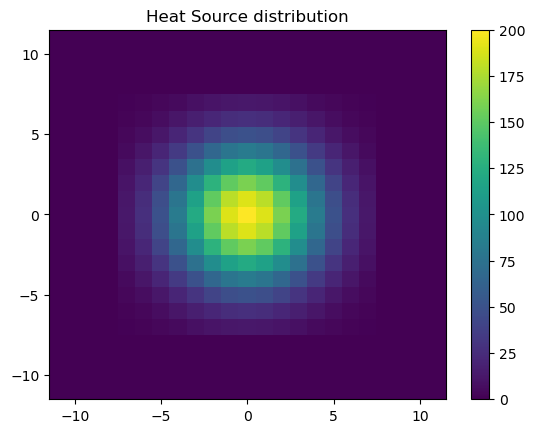

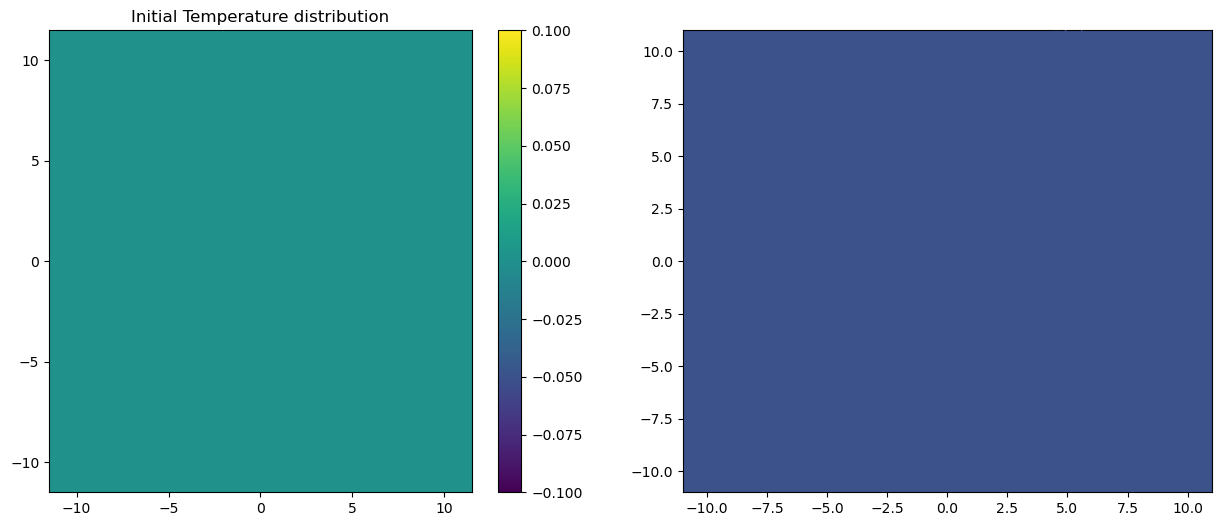

In [ ]:
from matplotlib import pyplot as plt, animation as ani
import numpy as np
import scipy.signal as sc
import itertools

def gkern(l=5, sig=1.):
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

def make_Gaussian(Q,heat_source_array,size=5,sigma=1,position_from_centre=(0,0),mode='peak'):
    heat_kernel = gkern(size,sigma)
    if mode=='peak': heat_kernel *= Q/heat_kernel[size//2][size//2]
    elif mode=='total': heat_kernel *= Q/np.sum(heat_kernel)
    if type(position_from_centre)==tuple and  type(position_from_centre[0])==int and type(position_from_centre[1])==int and len(position_from_centre)==2:
        for array_y_coord in range(max(0,position_from_centre[1]+len(heat_source_array)//2-size//2), min(len(heat_source_array),position_from_centre[1]+len(heat_source_array)//2+size//2 +1)):
            for array_x_coord in range(max(0,position_from_centre[0]+len(heat_source_array)//2-size//2), min(len(heat_source_array),position_from_centre[0]+len(heat_source_array)//2+size//2 +1)):
                heat_source_array[array_y_coord][array_x_coord] +=  heat_kernel[array_y_coord-position_from_centre[1]-len(heat_source_array)//2+size//2][array_x_coord-position_from_centre[0]-len(heat_source_array)//2+size//2]
    else:
        for position in position_from_centre:        
            for array_y_coord in range(max(0,position[1]+len(heat_source_array)//2-size//2), min(len(heat_source_array),position[1]+len(heat_source_array)//2+size//2 +1)):
                for array_x_coord in range(max(0,position[0]+len(heat_source_array)//2-size//2), min(len(heat_source_array),position[0]+len(heat_source_array)//2+size//2 +1)):
                    heat_source_array[array_y_coord][array_x_coord] +=  heat_kernel[array_y_coord-position[1]-len(heat_source_array)//2+size//2][array_x_coord-position[0]-len(heat_source_array)//2+size//2]

##Set these constants
k = 300
C = 1
Q = 200
p = 1

T_boundary = 0

L = 10 #units

time_length = 1
time_step = 0.001 # < 2 h^2/ multiply_term #

density = p
heat_source_in_power_density = Q
heat_capacity = C
mean_conduction_coefficient = k


box_half_length = 10    #All values are taken relative to particle length/spacing 1 hence, this effectively is half the width in measured in number of particles
box_particle_width = L/2/box_half_length #units
h=5
h_in_units = h*box_particle_width
##



X = np.linspace(-box_half_length,box_half_length,2*box_half_length+1)
Y = np.linspace(-box_half_length,box_half_length,2*box_half_length+1)

particle_mass = density * L**2 / 4 / box_half_length**2

###Set these if the density 'p', mass, heat capacity 'C' and/or conduction coeff 'k' are non-uniform
particle_mass_array = np.array([particle_mass for j in Y for i in X]).reshape(len(X),len(Y))
particle_density_array = np.array([density for j in Y for i in X]).reshape(len(X),len(Y))
conduction_coefficient_array = np.array([mean_conduction_coefficient for j in Y for i in X]).reshape(len(X),len(Y))
heat_capacity_array = np.array([heat_capacity for j in Y for i in X]).reshape(len(X),len(Y))
###

heat_source_array = np.zeros([len(X),len(Y)])



##Set this to set heat source
# heat_source_array[2][2]=10
# make_Gaussian(Q, heat_source_array,position_from_centre=[(-2,-2),(-2,2),(2,-2),(2,2)])
make_Gaussian(Q, heat_source_array,size=15,sigma=3,mode='peak',position_from_centre=(0,0))
###

Z = np.zeros([len(Y),len(X)],dtype=float)



### Set this for initial temperature (w.r.t T_boundary)
# Z += 100
# make_Gaussian(200, Z,size=15,sigma=3,mode='peak',position_from_centre=(10,10))
####

X_bound,Y_bound = np.meshgrid(np.linspace(-box_half_length-1,box_half_length+1,2*box_half_length+3),np.linspace(-box_half_length-1,box_half_length+1,2*box_half_length+3))
Z_array=[np.pad(Z+T_boundary,pad_width=1, mode='constant',constant_values=T_boundary)]


fig,axs = plt.subplots(1,1) 
source_plot=axs.pcolor(X_bound,Y_bound,np.pad(heat_source_array,pad_width=1, mode='constant',constant_values=0),shading='auto')
fig.colorbar(source_plot)
plt.title("Heat Source distribution")
plt.show()

fig,axs = plt.subplots(1,2,figsize=(15,6)) 
source_plot=axs[0].pcolor(X_bound,Y_bound,Z_array[-1],shading='auto')
fig.colorbar(source_plot,ax=axs[0])
plot=axs[1].contourf(X_bound,Y_bound,Z_array[-1])
axs[1].clabel(plot, inline=False, fontsize=10)
axs[0].set_title("Initial Temperature distribution")
plt.show()


### Smoothing function
W_size = int(2*h)
W = np.array([15 / (7*np.pi*h**2) * (2/3 - 9/8 *(((i-W_size)**2+(j-W_size)**2)**0.5 /h)**2 + 19/32 *(((i-W_size)**2+(j-W_size)**2)**0.5 /h)**3 - 5/32 *(((i-W_size)**2+(j-W_size)**2)**0.5 /h)**4 ) for j in range(2*W_size+1) for i in range(2*W_size+1)])

W = np.where(W>0,W,0)
W = W / sum(W)
convolve_kernel = W.reshape(2*W_size+1,2*W_size+1)
W_peak = W[len(W)//2]
W_dash_X,W_dash_Y=np.gradient(convolve_kernel)
W_dash = -np.hypot(W_dash_X,W_dash_Y,dtype=np.float64)
####

multiply_term = 2*conduction_coefficient_array/heat_capacity_array/particle_density_array


show_step=False #To make step-plots
for t in np.linspace(time_step,time_length,int(time_length/time_step)):
    # Z = sc.convolve2d(Z,convolve_kernel,boundary='symm',mode='same')     
    Z_copy=np.array(Z)
    
    for T_x_coord,T_y_coord in itertools.product(range(len(Z)),range(len(Z))):
        delta_Z=0
        for W_x_coord,W_y_coord in itertools.product(range(-W_size, W_size),range(-W_size, W_size)):
            j_ord_x = T_x_coord+W_x_coord
            j_ord_y = T_y_coord+W_y_coord
            if W_dash[W_size+W_x_coord][W_size+W_y_coord] != 0 and (W_x_coord,W_y_coord) != (0,0):
                if j_ord_x>=0 and j_ord_y>=0 and j_ord_x<len(Z) and j_ord_y<len(Z) :
                    delta_Z += W_dash[W_size+W_x_coord][W_size+W_y_coord] * (Z_copy[T_x_coord][T_y_coord] - Z_copy[j_ord_x][j_ord_y])/(W_x_coord**2 + W_y_coord**2)**0.5 * particle_mass_array[j_ord_x][j_ord_y]/particle_density_array[j_ord_x][j_ord_y]
                else:
                    delta_Z += W_dash[W_size+W_x_coord][W_size+W_y_coord] * (Z_copy[T_x_coord][T_y_coord])/(W_x_coord**2 + W_y_coord**2)**0.5 * particle_mass/density #Assumed average mass and density outside box
                #else if wall is insulating: deltaZ+=0
                #else if wall is convecting: deltaZ += (Z_copy[T_x_coord][T_y_coord] + T_boundary) * ( - convection constant H/convection constant K)
                
        # Use this if the terms are not constant throughout the material
        Z[T_x_coord][T_y_coord] += delta_Z*multiply_term[T_x_coord][T_y_coord]*time_step
        
    Z += heat_source_array/heat_capacity_array/particle_density_array*time_step
    Z_array.append(np.pad(Z+T_boundary,pad_width=1, mode='constant',constant_values=T_boundary))
    # print(t)
    if show_step == True and (t%(time_step*5))<0.00001:  #The 5 determines 1 of 5 frames/steps is shown in plot
        fig, axs = plt.subplots(1, 1)
        plot=axs.pcolor(X_bound,Y_bound,Z_array[-1],vmin=np.min(Z), vmax=np.max(Z),shading ='auto')
        fig.colorbar(plot)
        plt.title("Temperature distribution at time t ="+str(t))
        plt.show()

fig,axs = plt.subplots(1,2,figsize=(15,6)) 
source_plot=axs[0].pcolor(X_bound,Y_bound,Z_array[-1],shading='auto')
fig.colorbar(source_plot,ax=axs[0])
plot=axs[1].contourf(X_bound,Y_bound,Z_array[-1])
axs[1].clabel(plot, inline=False, fontsize=10)
axs[0].set_title("Final Temperature distribution")
plt.show()  


fig, axs = plt.subplots(1, 2,gridspec_kw={'width_ratios': [7, 1]})
progressY = []
progressX = []
progress_plot, = axs[1].plot(progressX,progressY,linewidth=2)
axs[1].xaxis.set_tick_params(labelbottom=False)
axs[1].yaxis.set_tick_params(labelleft=False)
axs[1].set_xticks([0])
axs[1].set_yticks([])
axs[1].set_ylim(0,len(Z_array))
axs[1].set_xlim(-0.1,0.1)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].spines['left'].set_visible(False)
color_plot=axs[0].pcolor(X_bound,Y_bound,Z_array[0],vmin=np.min(Z_array), vmax=np.max(Z_array),shading ='auto')
fig.colorbar(color_plot,ax=axs[0])
axs[0].set_title('Conduction Animation for time ' + str(time_length)+' with time_step '+str(time_step))

# def animate(i):
#    cax.set_array(G[:-1, :-1, i].flatten())
def animate(frame_t):
    print(frame_t)
    color_plot.set_array(Z_array[frame_t].flatten()) 
    progressY = range(frame_t)
    progressX = [0 for i in progressY]
    progress_plot, = axs[1].plot(progressX,progressY)

anim = ani.FuncAnimation(fig, animate, interval=10, frames=len(Z_array))
anim.save('Conduction Animation for ' + str(time_length)+' with time_step '+str(time_step)+ '.gif')
plt.show()